In [1]:
!python3 -m pip install -r requirements.txt

In [2]:
from dotenv import dotenv_values
import matplotlib.pyplot as plt
import pandas as pd

config = dotenv_values(".env")
df = pd.read_csv(str(config["WOS_DATA"]), sep="\t", usecols=["AU", "C1", "AF", "TI", "SO", "C3"])

In [3]:
df.head(5)

,AU,AF,TI,SO,C1,C3
0,"Zhang, H; Zhang, ZY; Zhang, L; Yang, YF; Kang,...","Zhang, Hong; Zhang, Zeyu; Zhang, Lei; Yang, Yi...",Object Tracking for a Smart City Using IoT and...,SENSORS,"[Zhang, Hong; Zhang, Zeyu; Zhang, Lei; Yang, Y...",Beihang University; University of Massachusett...
1,"Yar, H; Imran, AS; Khan, ZA; Sajjad, M; Kastra...","Yar, Hikmat; Imran, Ali Shariq; Khan, Zulfiqar...",Towards Smart Home Automation Using IoT-Enable...,SENSORS,"[Yar, Hikmat; Sajjad, Muhammad] Islamia Coll P...",University of Peshawar; Norwegian University o...
2,"Gheisari, M; Wang, GJ; Chen, SH","Gheisari, Mehdi; Wang, Guojun; Chen, Shuhong",An Edge Computing-enhanced Internet of Things ...,COMPUTERS & ELECTRICAL ENGINEERING,"[Gheisari, Mehdi; Wang, Guojun; Chen, Shuhong]...",Guangzhou University; State University System ...
3,"Hossain, SKA; Rahman, MA; Hossain, MA","Hossain, S. K. Alamgir; Rahman, Md Anisur; Hos...",Edge computing framework for enabling situatio...,JOURNAL OF PARALLEL AND DISTRIBUTED COMPUTING,"[Hossain, S. K. Alamgir; Rahman, Md Anisur] Kh...",Khulna University; King Saud University
4,"Wu, TY; Kong, FF; Wang, LY; Chen, YC; Kumari, ...","Wu, Tsu-Yang; Kong, Fangfang; Wang, Liyang; Ch...",Toward Smart Home Authentication Using PUF and...,SENSORS,"[Wu, Tsu-Yang; Kong, Fangfang; Wang, Liyang; P...",Shandong University of Science & Technology; U...


In [4]:
print(len(df))

9949


## Most published countries

In [5]:
df = df[df["C1"].notna()]
df = df.copy()

In [6]:
def extract_main_author_address(address):
  if isinstance(address, str):
    parts = address.split("; [")
    return parts[0].split("] ")[1] if "] " in parts[0] else parts[0]
  raise ValueError(f":Address is not string: {address}")

df["main_author_address"] = df["C1"].apply(extract_main_author_address)

In [7]:
def extract_country(address):
  if isinstance(address, str):
    # Special case for USA at the end with state and zip
    if address.strip().endswith("USA"):
      return "USA"
    parts = address.split(",")
    if len(parts) <= 1:
      raise ValueError(f"Address does not contain multiple parts: {address}")
    return parts[-1].strip()
  raise ValueError(f"Address is not string: {address}")

df["country"] = df["main_author_address"].apply(extract_country)

In [8]:
df["country"] = df["country"].replace("Peoples R China", "China")

In [9]:
# show unique countries and their occurrences
country_counts = df["country"].value_counts()
print(country_counts)

country
China          4889
India           686
South Korea     506
USA             478
Spain           284
               ... 
Syria             1
Venezuela         1
Mauritius         1
Cambodia          1
Bulgaria          1
Name: count, Length: 97, dtype: int64


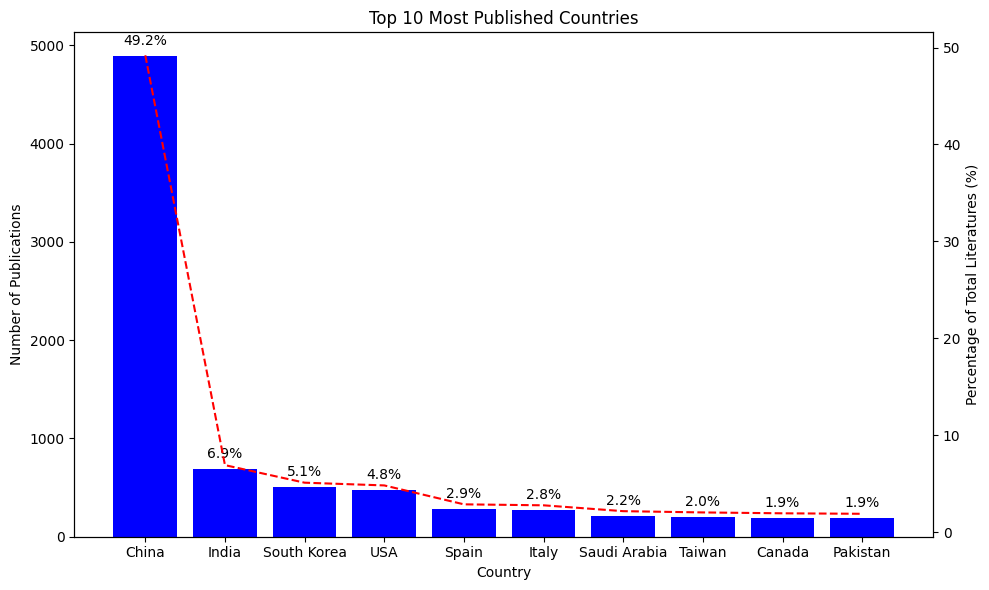

In [10]:

top_n = 10
top_countries = country_counts.head(top_n)
total_literatures = len(df)
percentages = (top_countries / total_literatures) * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(top_countries.index, top_countries.values, color='blue', label='Number of literatures published')
ax1.set_ylabel('Number of Publications')
ax1.set_xlabel('Country')
ax1.set_title('Top 10 Most Published Countries')

# Add percentage number to the top of each bar
for i, bar in enumerate(bars):
  height = bar.get_height()
  percent = percentages.iloc[i]
  ax1.text(
    bar.get_x() + bar.get_width() / 2,
    height + 80,  # move the label higher above the bar
    f'{percent:.1f}%',
    ha='center',
    va='bottom',
    fontsize=10,
    color='black'
  )

ax2 = ax1.twinx()
ax2.plot(top_countries.index, percentages, 'r--', label='Percentage of Total')
ax2.set_ylabel('Percentage of Total Literatures (%)')

fig.tight_layout()
plt.show()

## Most published research institutions

## Geo visualization of the most published countries

In [11]:
print(df["C3"].isna().sum())
df_institutions = df[df["C3"].notna()].copy()
print(df_institutions["C3"].isna().sum())

215
0


In [12]:
def extract_main_institution(x):
	if isinstance(x, str):
		return x.split(";")[0]
	raise ValueError(f"Main institution is not string: {x}")

df_institutions["main_institution"] = df_institutions["C3"].apply(extract_main_institution)

In [13]:
df_institutions["main_institution"].unique()
# write unique institutions to config["INSTITUTIONS_GEO_DATA"] as json array
import json
with open(config["INSTITUTIONS"], "w") as f:
    json.dump(df_institutions["main_institution"].unique().tolist(), f)

## Geo visualization of published

In [14]:
df_institutions_geo = pd.read_json(config["INSTITUTIONS_GEO_PROCESSED_DATA"], orient="index")

df_institutions_geo.head(5)

,latitude,longitude,address
Beihang University,39.980943,116.340979,"北京航空航天大学(学院路校区), 37, 学院路, 花园路街道, 东升镇, 海淀区, 北京市..."
University of Peshawar,34.010555,71.483316,"جامعہ پشاور, Agricultural University Road, یون..."
Guangzhou University,23.044650,113.363155,"广州大学(大学城校区), 230, 大学城外环西路, 小谷围街道, 番禺区, 广州市, 广东..."
Khulna University,22.801444,89.534237,"Khulna University, Khulna-Satkhira Highway, জি..."
Shandong University of Science & Technology,36.001464,120.116366,"山东科技大学(青岛校区), 579, 前湾港路, 辛安街道, 青岛西海岸新区（黄岛区）, 青..."


In [15]:
import plotly.express as px

fig = px.scatter_geo(df_institutions_geo, lat='latitude', lon='longitude')
fig.show()